In [2]:
# =============================================================================
# Data Processing and Analysis
# =============================================================================
import pandas as pd
import numpy as np

# =============================================================================
# Visualization
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# =============================================================================
# Machine Learning - Preprocessing and Model Selection
# =============================================================================
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# =============================================================================
# Machine Learning - Models and Imbalanced Data Handling
# =============================================================================
import lightgbm as lgb
from imblearn.pipeline import Pipeline as ImbPipeline 
from imblearn.over_sampling import SMOTE

# =============================================================================
# Machine Learning - Evaluation Metrics
# =============================================================================
from sklearn.metrics import (
    make_scorer, 
    recall_score, 
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    precision_recall_curve, 
    auc
)

# =============================================================================
# Hyperparameter Tuning
# =============================================================================
from scipy.stats import uniform, randint

Credit Card Fraud dataset loaded successfully.
--------------------------------------------------
First 5 rows of the dataset:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



--------------------------------------------------
Dataset Shape (rows, columns): (284807, 31)
--------------------------------------------------
Class distribution (0: Legitimate, 1: Fraud):
Class
0    284315
1       492
Name: count, dtype: int64

Proportion of total:


,Proportion,proportion
0,0,0.998273
1,1,0.001727


--------------------------------------------------


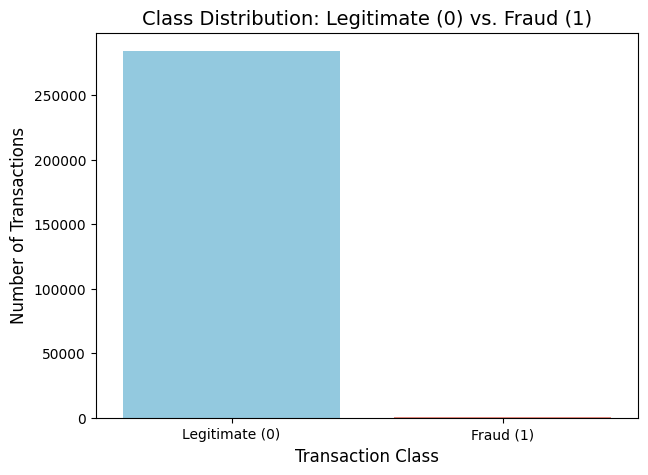

In [4]:
# Define the path to the dataset
DATA_PATH = "creditcard.csv" 

try:
    df = pd.read_csv(DATA_PATH) 
    print("Credit Card Fraud dataset loaded successfully.")
    print("--------------------------------------------------")
    print("First 5 rows of the dataset:")
    display(df.head()) 
    print("\n--------------------------------------------------")
    print(f"Dataset Shape (rows, columns): {df.shape}") 
    print("--------------------------------------------------")
    print("Class distribution (0: Legitimate, 1: Fraud):")
    class_counts = df['Class'].value_counts() 
    class_proportion = df['Class'].value_counts(normalize=True) 
    print(class_counts)
    print("\nProportion of total:")
    display(class_proportion.reset_index().rename(
        columns={'index': 'Class_Label', 'Class': 'Proportion'} 
    ))
    print("--------------------------------------------------")
    
    plt.figure(figsize=(7, 5))
    custom_palette = {0: "skyblue", 1: "salmon"}
    sns.countplot(x='Class', data=df, hue='Class', palette=custom_palette, legend=False) 
    plt.title('Class Distribution: Legitimate (0) vs. Fraud (1)', fontsize=14)
    plt.xlabel('Transaction Class', fontsize=12)
    plt.ylabel('Number of Transactions', fontsize=12)
    plt.xticks([0, 1], ['Legitimate (0)', 'Fraud (1)']) 
    plt.show()
    
except FileNotFoundError:
    print(f"Error: '{DATA_PATH}' was not found. Please ensure the file is in the correct path relative to your notebook.")
    df = None

In [6]:
# Ensure df is loaded from Listing 8.1
if df is not None:
    df_proc = df.copy() # Work on a copy

    # Scale 'Amount' and 'Time' features using StandardScaler
    scaler = StandardScaler()
    df_proc['scaled_amount'] = scaler.fit_transform(df_proc['Amount'].values.reshape(-1, 1))
    df_proc['scaled_time'] = scaler.fit_transform(df_proc['Time'].values.reshape(-1, 1))
    
    # Drop the original, unscaled 'Time' and 'Amount' columns
    df_proc.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    # Optional: Reorder columns to move 'Class' to the end for convenience
    if 'Class' in df_proc.columns:
        # Ensure 'Class' is the last column
        cols = [col for col in df_proc.columns if col != 'Class'] + ['Class']
        df_proc = df_proc[cols]

    # Separate features (X) and the target variable (y)
    X = df_proc.drop('Class', axis=1)
    y = df_proc['Class']

    # Split data into training and testing sets (e.g., 70% train, 30% test)
    # stratify=y ensures class proportions are maintained in both splits.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print("Data preprocessing (scaling and splitting) completed.")
    print("--------------------------------------------------")
    print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
    print(f"Shape of X_test: {X_test.shape}, Shape of y_test: {y_test.shape}")
    print("--------------------------------------------------")
    print("Fraud proportion in y_train (original, imbalanced):")
    display(y_train.value_counts(normalize=True).reset_index().rename(
        columns={'index': 'Class_Label', 'Class': 'Class_Label'}))
    print("--------------------------------------------------")
    print("Fraud proportion in y_test (original, imbalanced):")
    display(y_test.value_counts(normalize=True).reset_index().rename(
        columns={'index': 'Class_Label', 'Class': 'Class_Label'}))
    print("--------------------------------------------------")
    
else:
    print("DataFrame 'df' was not loaded in Listing 8.1. Cannot proceed with preprocessing.")

Data preprocessing (scaling and splitting) completed.
--------------------------------------------------
Shape of X_train: (199364, 30), Shape of y_train: (199364,)
Shape of X_test: (85443, 30), Shape of y_test: (85443,)
--------------------------------------------------
Fraud proportion in y_train (original, imbalanced):


,Class_Label,proportion
0,0,0.998275
1,1,0.001725


--------------------------------------------------
Fraud proportion in y_test (original, imbalanced):


,Class_Label,proportion
0,0,0.998268
1,1,0.001732


--------------------------------------------------


In [7]:
# Assuming X_train, y_train are available from Listing 8.2 (original imbalanced training data)

# Define the machine learning pipeline
pipeline_lgbm_rs = ImbPipeline([
    ('smote', SMOTE(random_state=42)),  
    ('classifier', lgb.LGBMClassifier(random_state=42, n_jobs=1)) # Using n_jobs=1 in LGBM
])

# Define parameter distributions for RandomizedSearchCV to sample from
param_dist_lgbm_rs = {
    'classifier__n_estimators': randint(80, 151),       
    'classifier__learning_rate': uniform(0.01, 0.09),   
    'classifier__num_leaves': randint(20, 41),          
    'classifier__reg_alpha': uniform(0, 0.5),           
    'classifier__reg_lambda': uniform(0, 0.5),          
    'classifier__min_child_samples': randint(20, 61),   
    'classifier__colsample_bytree': uniform(0.6, 0.3),  
    'classifier__subsample': uniform(0.6, 0.3),         
    'smote__k_neighbors': randint(3, 8),                
    'smote__sampling_strategy': [0.3, 0.5, 0.7, 'auto'] 
}

# Define the scoring metric for optimization. For fraud, recall of the positive class is often prioritized.
recall_scorer_fraud = make_scorer(recall_score, pos_label=1)

# Initialize RandomizedSearchCV
random_search_final = RandomizedSearchCV(
    estimator=pipeline_lgbm_rs, 
    param_distributions=param_dist_lgbm_rs, 
    n_iter=10,  # Number of parameter settings that are sampled
    scoring=recall_scorer_fraud, 
    cv=5,       # 5-fold cross-validation
    verbose=1,  # To see progress during fitting
    random_state=42, # For reproducibility
    n_jobs=-1  # Use all available CPU cores for parallelizing trials
) 

print("RandomizedSearchCV and pipeline defined. Ready for training and hyperparameter search.")
print(f"The following hyperparameter distributions will be sampled: {list(param_dist_lgbm_rs.keys())}")

RandomizedSearchCV and pipeline defined. Ready for training and hyperparameter search.
The following hyperparameter distributions will be sampled: ['classifier__n_estimators', 'classifier__learning_rate', 'classifier__num_leaves', 'classifier__reg_alpha', 'classifier__reg_lambda', 'classifier__min_child_samples', 'classifier__colsample_bytree', 'classifier__subsample', 'smote__k_neighbors', 'smote__sampling_strategy']


In [8]:
print("\nStarting RandomizedSearchCV (cv=5, n_iter=10) to train the LightGBM model...")
print("This process may take several minutes. Verbose output will show progress.")

# Fit RandomizedSearchCV on the original imbalanced training data (X_train, y_train)
random_search_final.fit(X_train, y_train) 

print("\nRandomizedSearchCV hyperparameter tuning completed.")
print("--------------------------------------------------")
# Display the best parameters found
print("Best parameters found by RandomizedSearchCV:")
print(random_search_final.best_params_) 
print("\nBest cross-validated recall score (for fraud class) achieved during search:")
print(f"{random_search_final.best_score_:.4f}") 
print("--------------------------------------------------")

# The best_estimator_ attribute now holds our optimally tuned pipeline
best_model_final = random_search_final.best_estimator_


Starting RandomizedSearchCV (cv=5, n_iter=10) to train the LightGBM model...
This process may take several minutes. Verbose output will show progress.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

RandomizedSearchCV hyperparameter tuning completed.
--------------------------------------------------
Best parameters found by RandomizedSearchCV:
{'classifier__colsample_bytree': 0.6021198915659152, 'classifier__learning_rate': 0.012075618253727417, 'classifier__min_child_samples': 46, 'classifier__n_estimators': 138, 'classifier__num_leave


--- Performance of Tuned LightGBM Model on UNSEEN TEST SET ---

Confusion Matrix (Test Set):


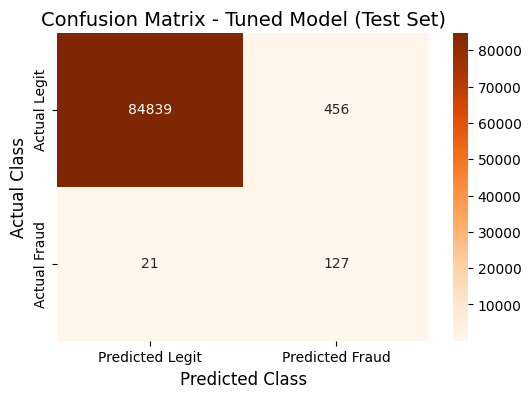


Classification Report (Test Set):
                precision    recall  f1-score   support

Legitimate (0)       1.00      0.99      1.00     85295
Fraudulent (1)       0.22      0.86      0.35       148

      accuracy                           0.99     85443
     macro avg       0.61      0.93      0.67     85443
  weighted avg       1.00      0.99      1.00     85443


AUC-ROC Score (Test Set): 0.9728
AUC-PR Score (Test Set): 0.7247
--------------------------------------------------------------------


In [9]:
# Make predictions on the (imbalanced) test set
y_pred_test = best_model_final.predict(X_test)
y_pred_proba_test = best_model_final.predict_proba(X_test)[:, 1] # Probabilities for the positive class (fraud)

print("\n--- Performance of Tuned LightGBM Model on UNSEEN TEST SET ---")
print("\nConfusion Matrix (Test Set):")
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Predicted Legit', 'Predicted Fraud'], 
            yticklabels=['Actual Legit', 'Actual Fraud'])
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.title('Confusion Matrix - Tuned Model (Test Set)', fontsize=14)
plt.show()

print("\nClassification Report (Test Set):")
# A. The classification report provides precision, recall, and F1-score for each class.
print(classification_report(y_test, y_pred_test, target_names=['Legitimate (0)', 'Fraudulent (1)'])) 

auc_roc_test = roc_auc_score(y_test, y_pred_proba_test)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test)
auc_pr_test = auc(recall_test, precision_test) # B. AUC-PR is particularly insightful for imbalanced data.

print(f"\nAUC-ROC Score (Test Set): {auc_roc_test:.4f}")
print(f"AUC-PR Score (Test Set): {auc_pr_test:.4f}")
print("--------------------------------------------------------------------")


In [10]:
# Create a DataFrame with true labels and predicted fraud probabilities for the test set
pred_df_eval_test = pd.DataFrame({'true_label': y_test, 'predicted_proba': y_pred_proba_test})
# Sort transactions by predicted fraud probability in descending order (highest probability first)
pred_df_sorted_eval_test = pred_df_eval_test.sort_values(by='predicted_proba', ascending=False) # A

# Define the percentage thresholds for our analysis
percentage_thresholds = [0.001, 0.002, 0.005, 0.01, 0.05] # Top 0.1%, 0.2%, 0.5%, 1%, 5%
total_test_samples = len(pred_df_sorted_eval_test)
total_actual_frauds_in_test = pred_df_sorted_eval_test['true_label'].sum() # B

print(f"Data prepared for Top-N% analysis. Total test samples: {total_test_samples}, Total actual frauds: {total_actual_frauds_in_test}")


Data prepared for Top-N% analysis. Total test samples: 85443, Total actual frauds: 148


In [11]:

print(f"\n--- Strategic Analysis Table: Precision & Fraud Capture at Top N% (Test Set) ---")
print("----------------------------------------------------------------------------------------------------------")
# Header for the results table
print(f"{'Top %':<8} | {'Num. Flagged':<12} | {'Actual Frauds':<15} | {'Precision@TopN%':<18} | {'Fraud Capture Rate@N%':<22}")
print("----------------------------------------------------------------------------------------------------------")

results_top_n_percent_list = [] # This list will store data for our subsequent plot

for perc_threshold in percentage_thresholds: # Renamed 'perc' to 'perc_threshold' for clarity
    num_to_select = int(round(total_test_samples * perc_threshold))
    if num_to_select == 0 and total_test_samples * perc_threshold > 0: 
        num_to_select = 1 # Ensure at least 1 sample if percentage is very small but > 0
    
    if num_to_select == 0: 
        # Handle cases where num_to_select is 0
        print(f"{perc_threshold*100:<7.1f}% | {num_to_select:<12} | {'0':<15} | {'0.0000':<18} | {'0.0000':<22}")
        results_top_n_percent_list.append({
            'Top %': f"{perc_threshold*100:.1f}%", 'Num. Flagged': num_to_select,
            'Actual Frauds': 0, 'Precision@TopN%': 0.0, 'Fraud Capture Rate@N%': 0.0 
        })
        continue

    # Select the top N% predictions from the sorted DataFrame
    top_n_percent_slice_df = pred_df_sorted_eval_test.head(num_to_select) # A
    
    # Count actual frauds within this top N% slice
    actual_frauds_in_slice = top_n_percent_slice_df['true_label'].sum()
    
    # Calculate precision for this N% slice
    precision_in_slice = actual_frauds_in_slice / num_to_select if num_to_select > 0 else 0.0
    
    # Calculate Fraud Capture Rate for this N% slice
    capture_rate_in_slice = actual_frauds_in_slice / total_actual_frauds_in_test if total_actual_frauds_in_test > 0 else 0.0 # B
    
    print(f"{perc_threshold*100:<7.1f}% | {num_to_select:<12} | {actual_frauds_in_slice:<15} | {precision_in_slice:<18.4f} | {capture_rate_in_slice:<22.4f}")
    
    results_top_n_percent_list.append({
        'Top %': f"{perc_threshold*100:.1f}%", 
        'Num. Flagged': num_to_select,
        'Actual Frauds': actual_frauds_in_slice,
        'Precision@TopN%': precision_in_slice,
        'Fraud Capture Rate@N%': capture_rate_in_slice
    })
print("----------------------------------------------------------------------------------------------------------")

# Create a DataFrame from the results, which will be used for plotting in the next listing
results_df_for_plotting = pd.DataFrame(results_top_n_percent_list) # C





--- Strategic Analysis Table: Precision & Fraud Capture at Top N% (Test Set) ---
----------------------------------------------------------------------------------------------------------
Top %    | Num. Flagged | Actual Frauds   | Precision@TopN%    | Fraud Capture Rate@N% 
----------------------------------------------------------------------------------------------------------
0.1    % | 85           | 70              | 0.8235             | 0.4730                
0.2    % | 171          | 115             | 0.6725             | 0.7770                
0.5    % | 427          | 122             | 0.2857             | 0.8243                
1.0    % | 854          | 127             | 0.1487             | 0.8581                
5.0    % | 4272         | 133             | 0.0311             | 0.8986                
----------------------------------------------------------------------------------------------------------


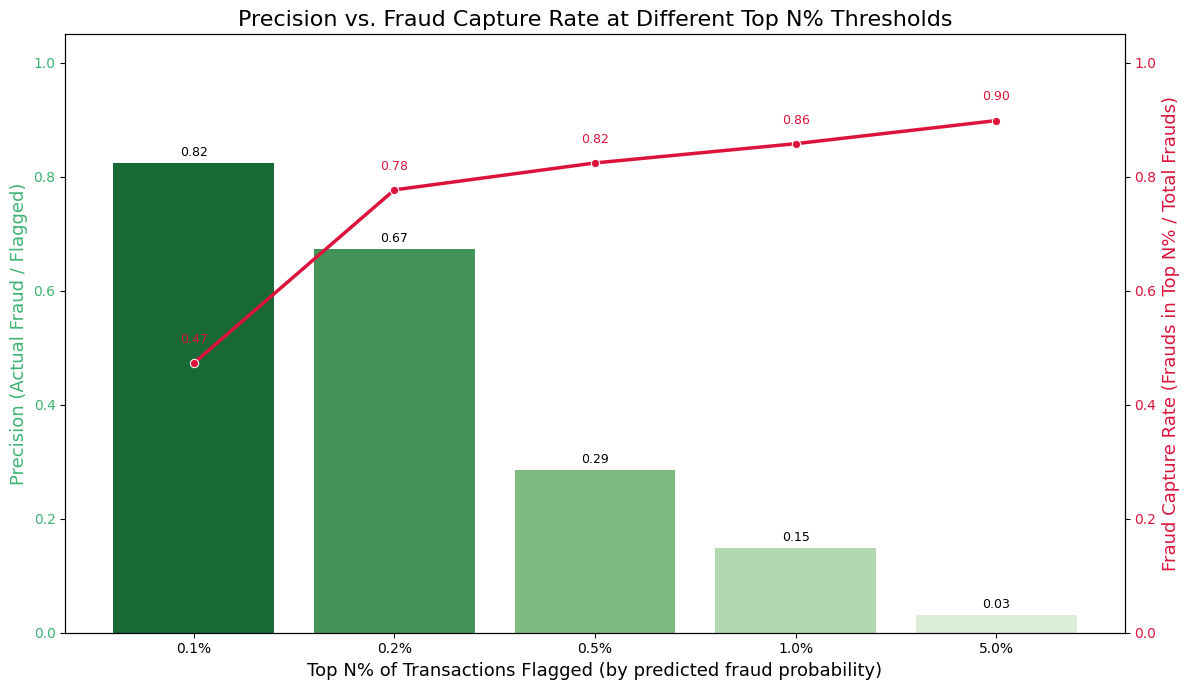

In [13]:
if not results_df_for_plotting.empty: 
    fig, ax1 = plt.subplots(figsize=(12, 7)) 
    
    color_precision = 'mediumseagreen' 
    ax1.set_xlabel('Top N% of Transactions Flagged (by predicted fraud probability)', fontsize=13)
    ax1.set_ylabel('Precision (Actual Fraud / Flagged)', fontsize=13, color=color_precision)
    barplot_precision = sns.barplot(x='Top %', y='Precision@TopN%', data=results_df_for_plotting, 
                                    palette='Greens_r', ax=ax1, hue='Top %', dodge=False, legend=False) 
    ax1.tick_params(axis='y', labelcolor=color_precision)
    ax1.set_ylim(0, 1.05) 
    for container in barplot_precision.containers: 
        ax1.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9, padding=3)

    ax2 = ax1.twinx()  
    color_capture_rate = 'crimson' 
    ax2.set_ylabel('Fraud Capture Rate (Frauds in Top N% / Total Frauds)', fontsize=13, color=color_capture_rate)
    x_indices_for_plot = np.arange(len(results_df_for_plotting['Top %'])) 
    sns.lineplot(x=x_indices_for_plot, y='Fraud Capture Rate@N%', data=results_df_for_plotting, 
                 color=color_capture_rate, marker='o', linewidth=2.5, ax=ax2, legend=False, sort=False) 
    ax2.tick_params(axis='y', labelcolor=color_capture_rate)
    ax2.set_ylim(0, 1.05) 
    for i, row_val in enumerate(results_df_for_plotting['Fraud Capture Rate@N%']):
         ax2.text(i, row_val + 0.03, f"{row_val:.2f}", color=color_capture_rate, 
                  ha="center", va='bottom', fontsize=9)
    
    ax1.set_xticks(x_indices_for_plot) 
    ax1.set_xticklabels(results_df_for_plotting['Top %']) 
    
    plt.title('Precision vs. Fraud Capture Rate at Different Top N% Thresholds', fontsize=16)
    fig.tight_layout()  
    plt.show()
else:
    print("\nPlotting skipped as 'results_df_for_plotting' is empty or was not generated in Listing 8.7.")
